# Задача 3. Творческая

Поставить такую задачу перед собой и ее решить, используя следующие вводные:

1. Это должна быть задача классического машинного обучения.
2. Продемонстрировать умение визуализировать данные.
3. Решение должно быть полным, работоспособным, с развернутым описанием
4. Задача не должна быть заимствована с GitHub, Kaggle, Хабра и т.д.
5. Использовать можно любой публичный датасет.

## Идея

### Проблема

Франшизы составляют значительную часть рынка B2B.
Основная ценность франшизы заключается в передаче знаний и правил работы. Изучение этих правил и их эффективное применение является ключом к успеху франчайзи.
Владельцы франшиз сталкиваются с необходимостью постоянно отвечать на вопросы, связанные с правилами франшизы, что требует времени и ресурсов.

### Решение

С помощью машинного обучения создать создать ИИ-помощника, который сможет автоматически отвечать на вопросы, связанные с правилами франшизы. Это может значительно упростить и ускорить процесс обучения и поддержки франчайзи, а также снизить затраты на коммуникации.

## Реализация

### Импорты

In [1]:
!pip install natasha --quiet
!pip install plotly wordcloud --quiet

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import re
import warnings
import nltk

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)

from IPython.display import display

warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords', quiet=True)

True

### Поиск и выбор базы

Погуглив не нашел хорошего списка правил франшины, особенно в формате вопрос-ответ. Принял решение, что в реальном проекте правила будут составлены похожим образом, поэтому для учебного проекта сгенерировал правила при помощи запроса Google Gemini: "представь, что ты открываешь свою франшизу и делаешь базу знаний для франчайзи, сгенерируй 100 неповторяющихся пар вопрос-ответ для базы знаний франшизы в формате csv". Далее эти вопросы дополнены их вариациями.

In [4]:
# Скачиваем датасет вопрос-ответ
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1XCCXj69JrQXhZNcrhk47rELM3QHXBNtL" -O rules.csv --quiet

In [5]:
# Скачиваем тестовый датасет вопрос-ответ
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1VvTFFN_eAFGjFquBQRS366uC9Ib6G-mx" -O test_rules.csv --quiet

In [6]:
# Открываем скачанный файл
df = pd.read_csv("./rules.csv", on_bad_lines='skip')

### Предобработка текста и векторизация

In [7]:
stop_words = set(stopwords.words('russian'))

# Инициализируем компоненты Natasha для обработки текста
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

# Функция для очистки и предобработки текста
def preprocess_text(text):
    if not isinstance(text, str): return ""

    text = text.lower()

    # Обрабатываем с помощью Natasha для лемматизации
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmatized_tokens = [token.lemma for token in doc.tokens]

    # Финальная очистка от стоп-слов и пунктуации
    text_clean = re.sub(r'[^а-яё\s]', '', " ".join(lemmatized_tokens))
    final_tokens = text_clean.split()
    processed_tokens = [word for word in final_tokens if word not in stop_words and len(word) >= 2]

    return " ".join(processed_tokens)

# Применяем предобработку к столбцам с вопросами и ответами
df['processed_question'] = df['question'].apply(preprocess_text)
df['processed_answer'] = df['answer'].apply(preprocess_text)

# Создаем единое поле для поиска, объединяя вопрос и ответ, но вопрос будет иметь больший вес за счет повторения
df['combined_text'] = df['processed_question'] + ' ' + df['processed_question'] + ' ' + df['processed_answer']

# Обучаем векторизатор на вопросах из нашей базы.
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

### Создание ИИ-помощника

In [8]:
def faq_assistant(user_question, faq_df, vectorizer, tfidf_matrix):

  # Настраиваем уровень, при котором помощник будет уверен, что нашел подходящую пару вопрос-ответ
  CONFIDENCE_THRESHOLD = 0.25

  # Обрабатываем вопрос пользователя
  processed_user_question = preprocess_text(user_question)
  user_question_vector = vectorizer.transform([processed_user_question])

  # Находим косинусное сходство
  similarities = cosine_similarity(user_question_vector, tfidf_matrix).flatten()

  best_index = similarities.argmax()
  confidence_score = similarities[best_index]

  # Возвращаем ответ, если уверенность достаточна
  if confidence_score >= CONFIDENCE_THRESHOLD:
      answer = faq_df.iloc[best_index]['answer']
      response = (f"{answer}\n"
                  f"(Уверенность в релевантности: {confidence_score:.2%})")
      return response
  else:
      return "К сожалению, я не нашел готового ответа на ваш вопрос. Пожалуйста, переформулируйте его."

### Проверка полученной модели

In [9]:
# Загружаем тестовую выборку
test_df = pd.read_csv("./test_rules.csv", on_bad_lines='skip')

# Функция для возврата найденного ответа и уверенности
def get_prediction_details(user_question, faq_df, vectorizer, tfidf_matrix):
    CONFIDENCE_THRESHOLD = 0.25
    processed_user_question = preprocess_text(user_question)
    user_question_vector = vectorizer.transform([processed_user_question])
    similarities = cosine_similarity(user_question_vector, tfidf_matrix).flatten()

    best_index = similarities.argmax()
    confidence_score = similarities[best_index]

    if confidence_score >= CONFIDENCE_THRESHOLD:

        return faq_df.iloc[best_index]['answer'], confidence_score
    else:

        return "Ответ не найден", confidence_score

analysis_data = []

# Проходим по каждому вопросу из тестового файла
for index, row in test_df.iterrows():
    test_question = row['question']
    correct_answer = row['answer']

    # Получаем предсказание модели и уверенность
    predicted_answer, confidence = get_prediction_details(test_question, df, vectorizer, tfidf_matrix)

    analysis_data.append({
        'Тестовый вопрос': test_question,
        'Ответ модели': predicted_answer,
        'Уверенность': confidence,
        'Степень уверенности': f"{confidence:.2%}",
        'Правильный ответ': correct_answer,
    })

# Представляем результат в виде таблицы
analysis_df = pd.DataFrame(analysis_data)

analysis_df['Результат'] = analysis_df.apply(
    lambda x: '✅ Верно' if x['Ответ модели'] == x['Правильный ответ'] else '❌ Ошибка',
    axis=1
)

print("Таблица с результатами анализа:")
display(analysis_df[['Тестовый вопрос', 'Ответ модели', 'Степень уверенности', 'Правильный ответ', 'Результат']])


# Создаем гистограмму по уверенности ответов
fig_hist = px.histogram(
    analysis_df,
    x='Уверенность',
    nbins=20,
    title='Гистограмма распределения уверенности модели'
)

# Добавляем вертикальную линию
fig_hist.add_vline(
    x=0.25, line_width=3, line_dash="dash", line_color="red",
    annotation_text=f"Порог = {0.25}", annotation_position="top left"
)
fig_hist.show()

# Создаем ящик с усами
fig_box = px.box(
    analysis_df,
    x='Результат',
    y='Уверенность',
    color='Результат',
    title='Сравнение уверенности для верных и ошибочных ответов',
    points="all",
    color_discrete_map={
        '✅ Верно': '#00CC96',
        '❌ Ошибка': '#EF553B'
    }
)
fig_box.show()

Таблица с результатами анализа:


,Тестовый вопрос,Ответ модели,Степень уверенности,Правильный ответ,Результат
0,Какие шаги легализации бизнеса требуются при з...,"Рекомендуются CRM, программы для учета, кассы,...",42.31%,Для открытия франшизы необходимо зарегистриров...,❌ Ошибка
1,Что включает в себя юридическая подготовка к о...,"Возможны собственные средства, банковские кред...",44.99%,Для открытия франшизы необходимо зарегистриров...,❌ Ошибка
2,Перечислите правовые формальности для старта р...,Для открытия франшизы необходимо зарегистриров...,31.33%,Для открытия франшизы необходимо зарегистриров...,✅ Верно
3,Какие юридические аспекты необходимо учесть пе...,Для открытия франшизы необходимо зарегистриров...,35.81%,Для открытия франшизы необходимо зарегистриров...,✅ Верно
4,Каковы основные требования законодательства к ...,Для открытия франшизы необходимо зарегистриров...,33.61%,Для открытия франшизы необходимо зарегистриров...,✅ Верно
...,...,...,...,...,...
95,Как защитить бизнес от финансовых потерь?,"Споры решаются путем переговоров, медиации или...",32.49%,"Диверсифицируйте доходы, контролируйте расходы...",❌ Ошибка
96,Какие существуют стратегии минимизации финансо...,Рекомендуется тщательно проверять все договоры...,46.69%,"Диверсифицируйте доходы, контролируйте расходы...",❌ Ошибка
97,Что делать для снижения вероятности финансовых...,"Диверсифицируйте доходы, контролируйте расходы...",39.21%,"Диверсифицируйте доходы, контролируйте расходы...",✅ Верно
98,Как франчайзи может управлять финансовыми угро...,"Диверсифицируйте доходы, контролируйте расходы...",44.18%,"Диверсифицируйте доходы, контролируйте расходы...",✅ Верно


Вывод: нельзя однозначно выбрать пороговое значение уверенности, т.к. при значении 0.47 отсечется почти половина правильных ответов. Зато почти не будет неправильных.

### Визуализация

Длины вопросов и ответов

In [10]:
# Подсчитываем длины
df['question_length'] = df['question'].apply(lambda x: len(str(x).split()))
df['answer_length'] = df['answer'].apply(lambda x: len(str(x).split()))

# Готовим данные для удобной визуализации
length_data = pd.concat([
    pd.DataFrame({'Тип': 'Вопросы', 'Длина (в словах)': df['question_length']}),
    pd.DataFrame({'Тип': 'Ответы', 'Длина (в словах)': df['answer_length']})
])

# Строим гистограмму
fig_hist = px.histogram(
    length_data,
    x='Длина (в словах)',
    color='Тип',
    barmode='overlay',
    opacity=0.7,
    title='<b>Распределение длин вопросов и ответов</b>',
    color_discrete_map={'Вопросы': 'royalblue', 'Ответы': 'seagreen'}
)
fig_hist.show()


Облако слов

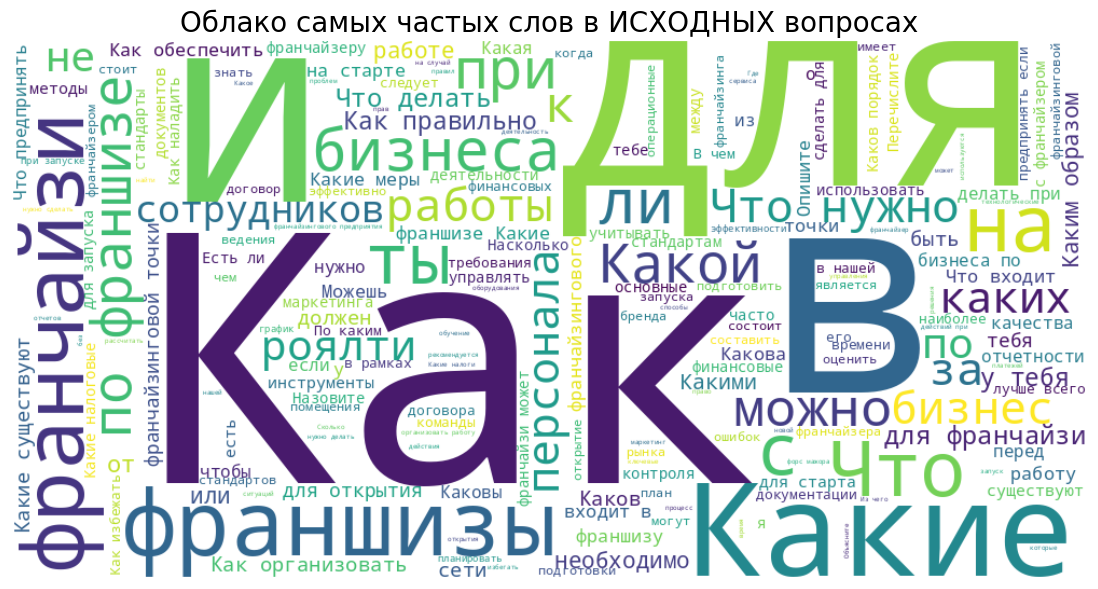

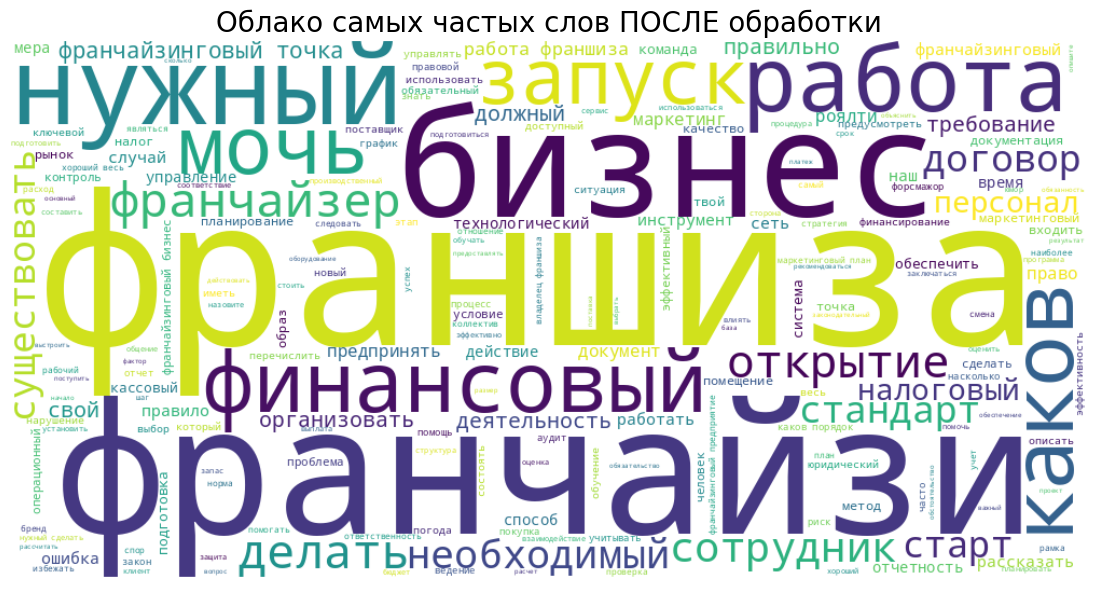

In [11]:
all_questions_raw = ' '.join(df['question'].dropna())
all_questions_processed = ' '.join(df['processed_question'].dropna())

def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        width=1000, height=500, background_color='white', colormap='viridis'
    ).generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

plot_wordcloud(all_questions_raw, 'Облако самых частых слов в ИСХОДНЫХ вопросах')
print()
plot_wordcloud(all_questions_processed, 'Облако самых частых слов ПОСЛЕ обработки')

## Работа ИИ-помощника

In [12]:
print("\n" + "="*50)
print(" Персональный ИИ-менеджер готов к работе")
print("="*50)
print("\nЗадайте ваш вопрос или напишите 'выход' для завершения.")

while True:
    question = input("\nВаш вопрос: ")
    if question.lower() == 'выход':
        print("\nСпасибо за ваши вопросы! Всего доброго.")
        break

    answer = faq_assistant(question, df, vectorizer, tfidf_matrix)
    print("\nВаш персональный ИИ-менеджер:")
    print(answer)


 Персональный ИИ-менеджер готов к работе

Задайте ваш вопрос или напишите 'выход' для завершения.

Ваш вопрос: На какой срок договор

Ваш персональный ИИ-менеджер:
Срок договора франчайзинга обычно варьируется от 1 до 10 лет с возможностью продления, что зависит от условий и успешности работы франчайзи.
(Уверенность в релевантности: 49.73%)

Ваш вопрос: Где брать сырье

Ваш персональный ИИ-менеджер:
К сожалению, я не нашел готового ответа на ваш вопрос. Пожалуйста, переформулируйте его.

Ваш вопрос: Кто поставщики

Ваш персональный ИИ-менеджер:
Устанавливайте четкие сроки, ведите графики платежей и поддерживайте хорошие отношения с поставщиками для надежности.
(Уверенность в релевантности: 59.18%)

Ваш вопрос: Как дела

Ваш персональный ИИ-менеджер:
У меня все хорошо, я забит задачами по франшизе и не жалуюсь! А вы как? Вернемся к делу?
(Уверенность в релевантности: 73.82%)

Ваш вопрос: Как обучать персонал

Ваш персональный ИИ-менеджер:
Обучение проводится регулярно, особенно при обн